## Imports

In [16]:
from torch.utils.data import Dataset, DataLoader
import scipy.io as sio
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import models
from torch import optim
import torch.nn.functional as F


## Dataset: Flower102

### Read Data

**Label Reference** 📕: https://www.robots.ox.ac.uk/~vgg/data/flowers/102/categories.html

In [2]:
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
!tar -xvzf /content/102flowers.tgz
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat

--2024-03-28 20:27:23--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/flowers-102/102flowers.tgz [following]
--2024-03-28 20:27:24--  https://thor.robots.ox.ac.uk/datasets/flowers-102/102flowers.tgz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344862509 (329M) [application/octet-stream]
Saving to: '102flowers.tgz'

102flowers.tgz      100%[===================>] 328.89M  20.9MB/s    in 17s     

2024-03-28 20:27:41 (19.6 MB/s) - '102flowers.tgz' saved [344862509/344862509]

tar (child): /content/102flowers.tgz: Cannot open: No such file or d

In [3]:
labels = sio.loadmat('imagelabels.mat')['labels']

### Custom Dataset

In [4]:
import tarfile 
  
# open file 
images = tarfile.open('/kaggle/working/102flowers.tgz') 
  
# extracting file 
images.extractall('/kaggle/working/images') 
  
images.close() 

In [5]:
import os
from os import listdir
 
# get the path or directory
folder_dir = "/kaggle/working/images/jpg"

img_paths = []

for image in os.listdir(folder_dir):
    img_paths.append("/kaggle/working/images/jpg/"+image)
    
labels = np.squeeze(labels)
labels.shape

for i in range(len(labels)):
    labels[i] = labels[i] -1
    

In [6]:
import pandas as pd
img_df = pd.DataFrame({
    'path': img_paths,
    'label': labels
})

img_df.head()

,path,label
0,/kaggle/working/images/jpg/image_03784.jpg,76
1,/kaggle/working/images/jpg/image_07362.jpg,76
2,/kaggle/working/images/jpg/image_00621.jpg,76
3,/kaggle/working/images/jpg/image_02787.jpg,76
4,/kaggle/working/images/jpg/image_03938.jpg,76


In [8]:
class CustomDataset(Dataset):  # needs to inherit dataset

    def __init__(self, df: pd.DataFrame, img_transforms=None): 
        self.df = df
        self.img_transforms = img_transforms
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        df_row = self.df.iloc[idx] # returns the row numbered idx

        img_path  = df_row['path'] 
        img_label = df_row['label'] 

        img = Image.open(img_path) # open the image by its path
        img_tensor = transforms.functional.to_tensor(img) # transform image to tensor

        if self.img_transforms is not None: # apply transforms if required
            img_tensor = self.img_transforms(img_tensor) 

        return img_tensor, img_label

In [9]:
from torch.utils.data import random_split # imported random_split
from torchvision import transforms

img_transform = transforms.Compose([
    transforms.Resize((64, 64), antialias=False)
])

img_dataset = CustomDataset(img_df, img_transform)

train_percent = int(len(img_dataset) * 0.7) #80% of data length for training
val_percent = len(img_dataset) - train_percent # 20% of dataset length for validation

train_split, val_percent = random_split(img_dataset, [train_percent, val_percent]) # splitting training and validation data

train_data = DataLoader(train_split, batch_size = 64, shuffle = True)
val_data = DataLoader(train_split, batch_size = 64, shuffle = False)

Number of channels in test_image:  torch.Size([3, 64, 64])


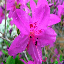

In [10]:
from PIL import Image

test_image = train_split[0][0]  # 0 for image part in (image, label) tuple.
# test_image = transforms.Resize(test_image, (250, 250), antialias=None)  # better visualization
print('Number of channels in test_image: ', test_image.shape)
transforms.functional.to_pil_image(test_image) 

# Using pretrained resnet

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # checks if machine supports cuda and if it does, we use that, otherwise cpu

print(device)

cuda


In [14]:
num_epochs = 10
lr = 1e-4

Using device cuda


Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 9.0000e-03.
Iterataion 0: Training Loss: 4.853231087159575, Validation Loss: 4.4361674490939365
Iteataion 0: Training Accuracy: 0.022679692951849267, Validation Accuracy  0.05704815073272854
Adjusting learning rate of group 0 to 8.1000e-03.
Iterataion 1: Training Loss: 4.529751182941908, Validation Loss: 3.9904224952954923
Iteataion 1: Training Accuracy: 0.03960223307745987, Validation Accuracy  0.13049546406140963
Adjusting learning rate of group 0 to 7.2900e-03.
Iterataion 2: Training Loss: 4.013124581133382, Validation Loss: 3.37400270579906
Iteataion 2: Training Accuracy: 0.11043265875785066, Validation Accuracy  0.2670969993021633
Adjusting learning rate of group 0 to 6.5610e-03.
Iterataion 3: Training Loss: 3.414660858304313, Validation Loss: 2.769819760590457
Iteataion 3: Training Accuracy: 0.24930216329378926, Validation Accuracy  0.46842288904396373
Adjusting learning rate of group 0 to 5.9

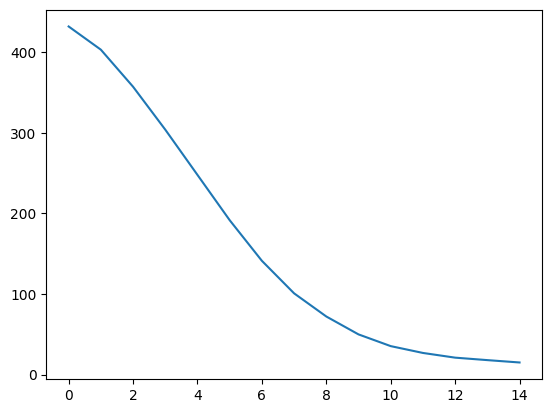

In [17]:
%%time

net=models.resnet18(pretrained=True)

net.conv1=nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) # in this line we odify the first convolotional layer, the 1  refers tp the number of channels, 64 is absed off the otiginal model

net=net.to(device)

net.fc=nn.Linear (in_features=512, out_features=102, bias=True)

net=net.to(device)
lr=.01
momentum=0.6
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, verbose=True)


ls=[]
for i in range(num_epochs + 5):
  loss_total=0
  loss_val=0
  acc_train=0
  total_train=0
  for ii,batch in enumerate(train_data):
    data=batch[0]
    label=batch[1]
    optimizer.zero_grad()
    data, label = data.to(device), label.to(device)
    logits = net(data)
    loss = F.cross_entropy(logits, label)
    loss_total+=loss.item()

    loss.backward()
    optimizer.step()
    out=torch.argmax(logits, dim=1)
    acc_train+=torch.sum(out==label)
    total_train+=logits.shape[0]

  acc_val=0
  total_val=0
  with torch.no_grad():
    for jj,batch in enumerate(val_data):
          data=batch[0]
          label=batch[1]
          data, label = data.to(device), label.to(device)
          logits = net(data)
          loss = F.cross_entropy(logits, label)
          loss_val+=loss.item()
          out=torch.argmax(logits, dim=1)
          acc_val+=torch.sum(out==label)
          total_val+=logits.shape[0]



  ls.append(loss_total)
  lr_scheduler.step()
  print(f"Iterataion {i}: Training Loss: {loss_total/ii}, Validation Loss: {loss_val/jj}")
  print(f"Iteataion {i}: Training Accuracy: {acc_train.item()/total_train}, Validation Accuracy  {acc_val.item()/total_val}")

plt.plot(ls)